# Testing the Slime Mould Algorithm

The Slime Mould Algorithm (SMA) is a bio-inspired optimizer based on the oscillation mode of slime mould in nature. Following CoFI's
    vector abstraction principle, this tool operates purely on user defined
    parameter vectors while supporting spatial regularization at the utility level.

Based on the paper:
    [Li, S., Chen, H., Wang, M., Heidari, A. A., & Mirjalili, S. (2020). Slime mould algorithm: A new method for stochastic optimization. Future Generation Computer Systems, 111, 300-323.](https://www.sciencedirect.com/science/article/pii/S0167739X19320941)

The python implementation of SMA used here is from [The mealpy initiative](https://mealpy.readthedocs.io/en/latest) by 
  [Van Thieu, Nguyen and Mirjalili, Seyedali (2023). MEALPY: An open-source library for latest meta-heuristic algorithms in Python, Journal of Systems Architecture,
   Elsevier, doi=10.1016/j.sysarc.2023.102871](https://www.sciencedirect.com/science/article/pii/S1383762123000504)

Interface to CoFI developed by by Juerg Hauser and Claude.
August 2025.

## Logging
MEALPY provides detailed information about the training process which while useful can be excessive. In this notebook we thus use CoFI's ability to pass a parameter to the underlying solver to suppress the logging. While CoFI knows nothing about MEALPY's loging behaviour we simply pass `log_to=None` to MEALPY. 

https://mealpy.readthedocs.io/en/latest/pages/general/advance_guide.html#log-training-process

## Imports and setup

In [13]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import seaborn as sns
import warnings
import logging
# CoFI imports
from cofi import BaseProblem, InversionOptions, Inversion

# Set style for beautiful plots
plt.style.use('default')
sns.set_palette("husl")
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

%matplotlib inline

##  Test Function: Modified Himmelblau Function

To demonstrate the Slime Mould algorithm we will use a modified version of the classic Himmelblau function, which is a well-known multi-modal optimization benchmark. The original Himmelblau function has four global minima, making it an excellent test case for global optimization algorithms. For this notebook  it has been modified to have a global minimum by adding a regularisation term, which results in a global minimum and three local minima

### Function Definition

$$f(x, y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2 + (x - 3)^2 + (y - 2)^2$$

The modification adds a regularisation term $(x - 3)^2 + (y - 2)^2$ that creates a preferred global minimum at $(3, 2)$.

In [14]:
def modified_himmelblau(x):
    """
    Modified Himmelblau function with additional regularization term.
    
    Original function has 4 global minima. The modification adds a bias
    towards the point (3, 2), making it the preferred global minimum.
    
    Args:
        x: array-like, [x1, x2] coordinates
        
    Returns:
        float: Function value
    """
    x1, x2 = x[0], x[1]
    # Original Himmelblau terms
    term1 = (x1**2 + x2 - 11)**2
    term2 = (x1 + x2**2 - 7)**2
    # Regularization term (bias towards (3, 2))
    term3 = (x1 - 3)**2 + (x2 - 2)**2
    
    return term1 + term2 + term3

# Test the function
test_point = [3.0, 2.0]
print(f" Function value at (3, 2): {modified_himmelblau(test_point):.6f}")
print(f" This should be close to the global minimum!")

 Function value at (3, 2): 0.000000
 This should be close to the global minimum!


##  Visualizing the Optimization Landscape

Let's visualize the modified Himmelblau function to understand the optimization challenge:

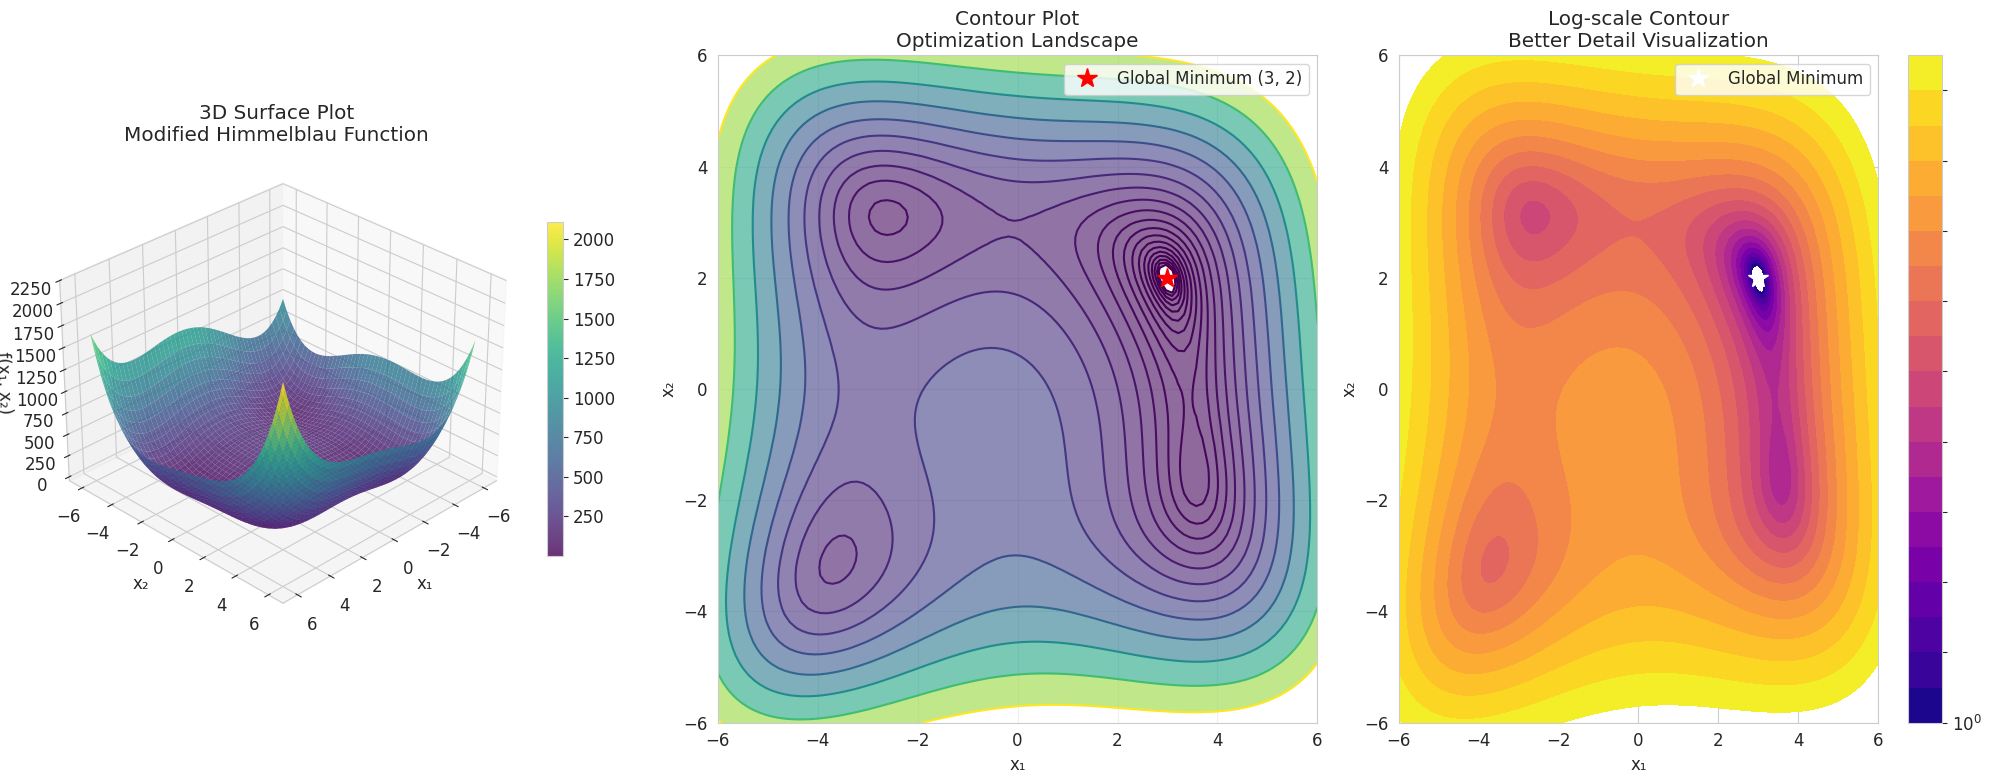

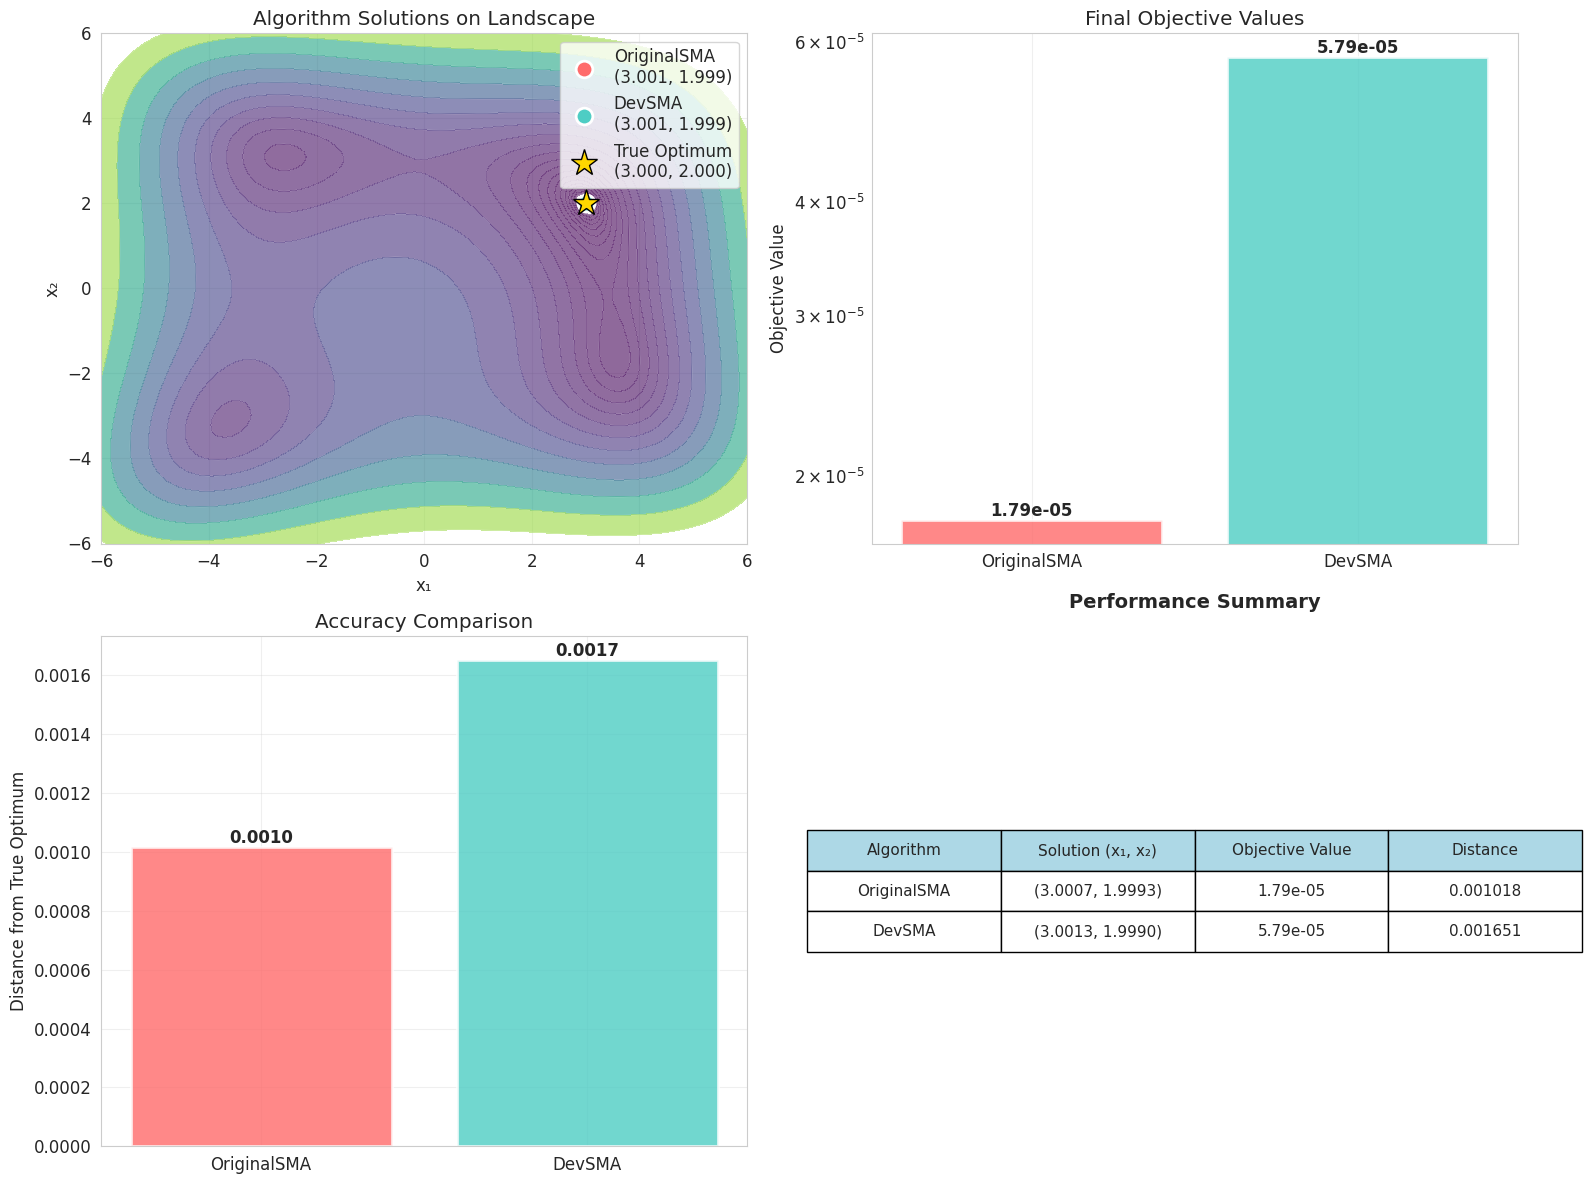

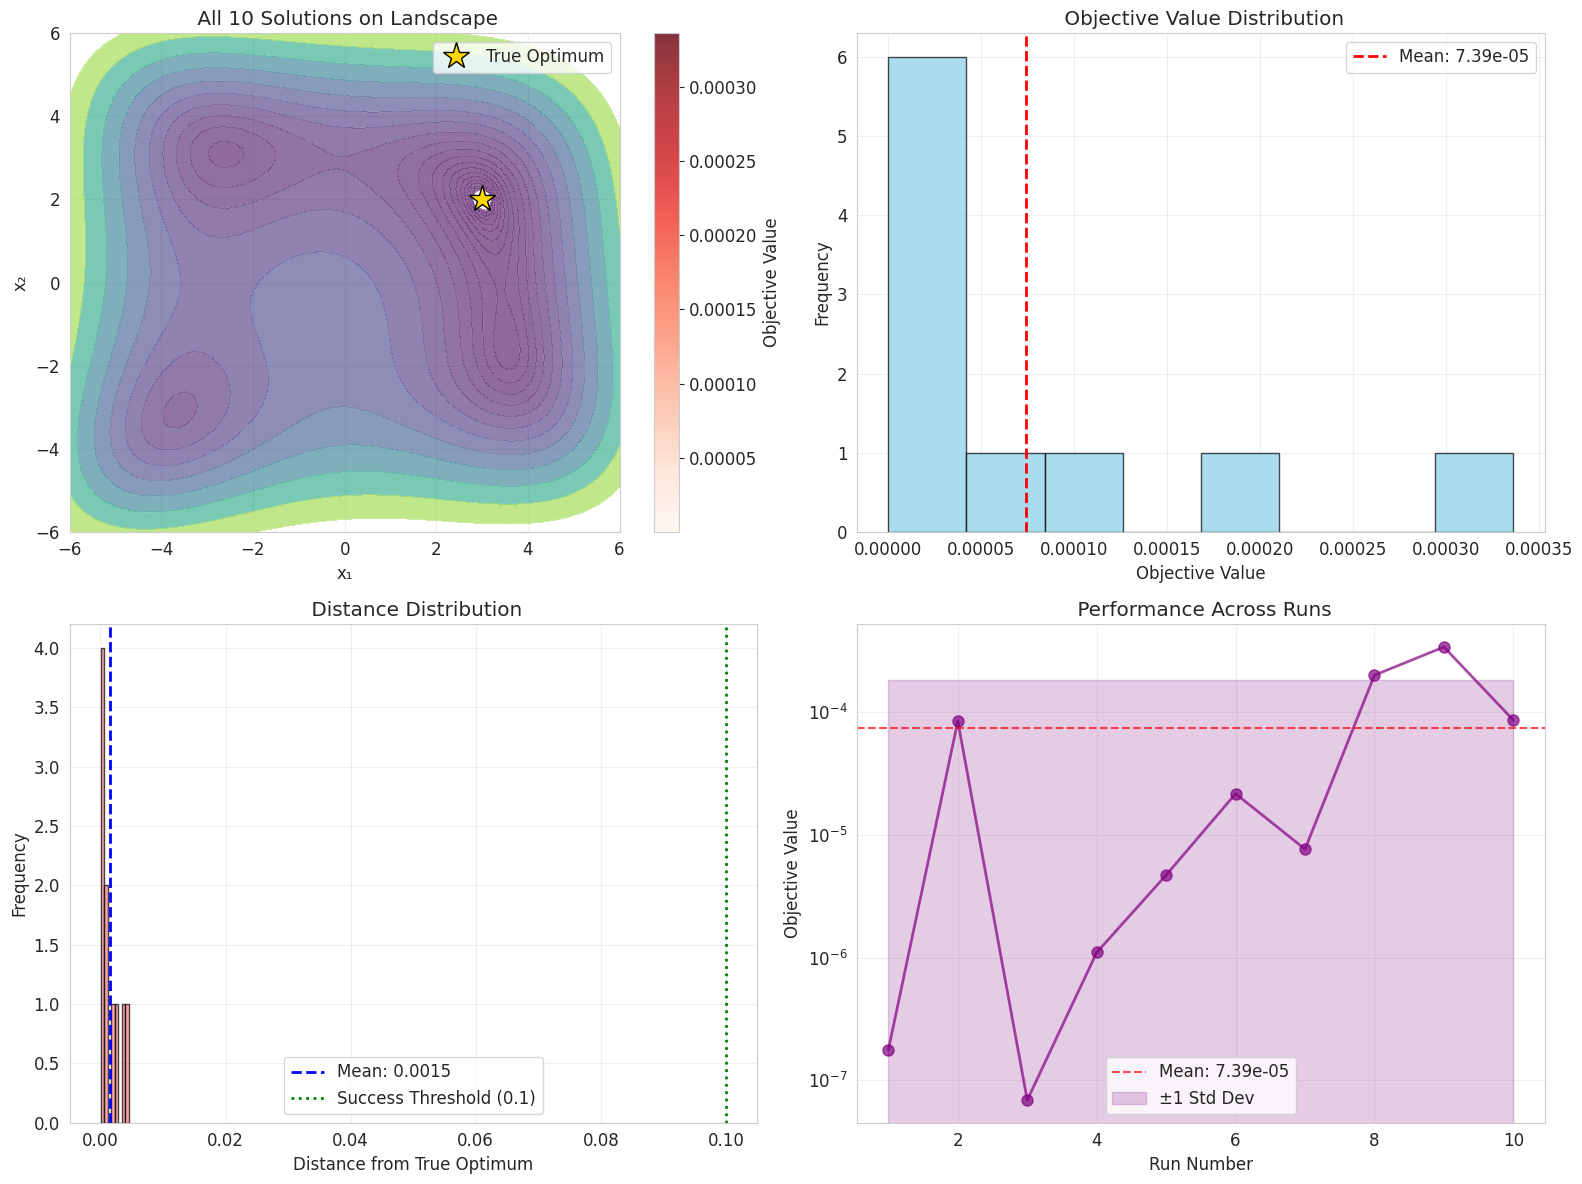

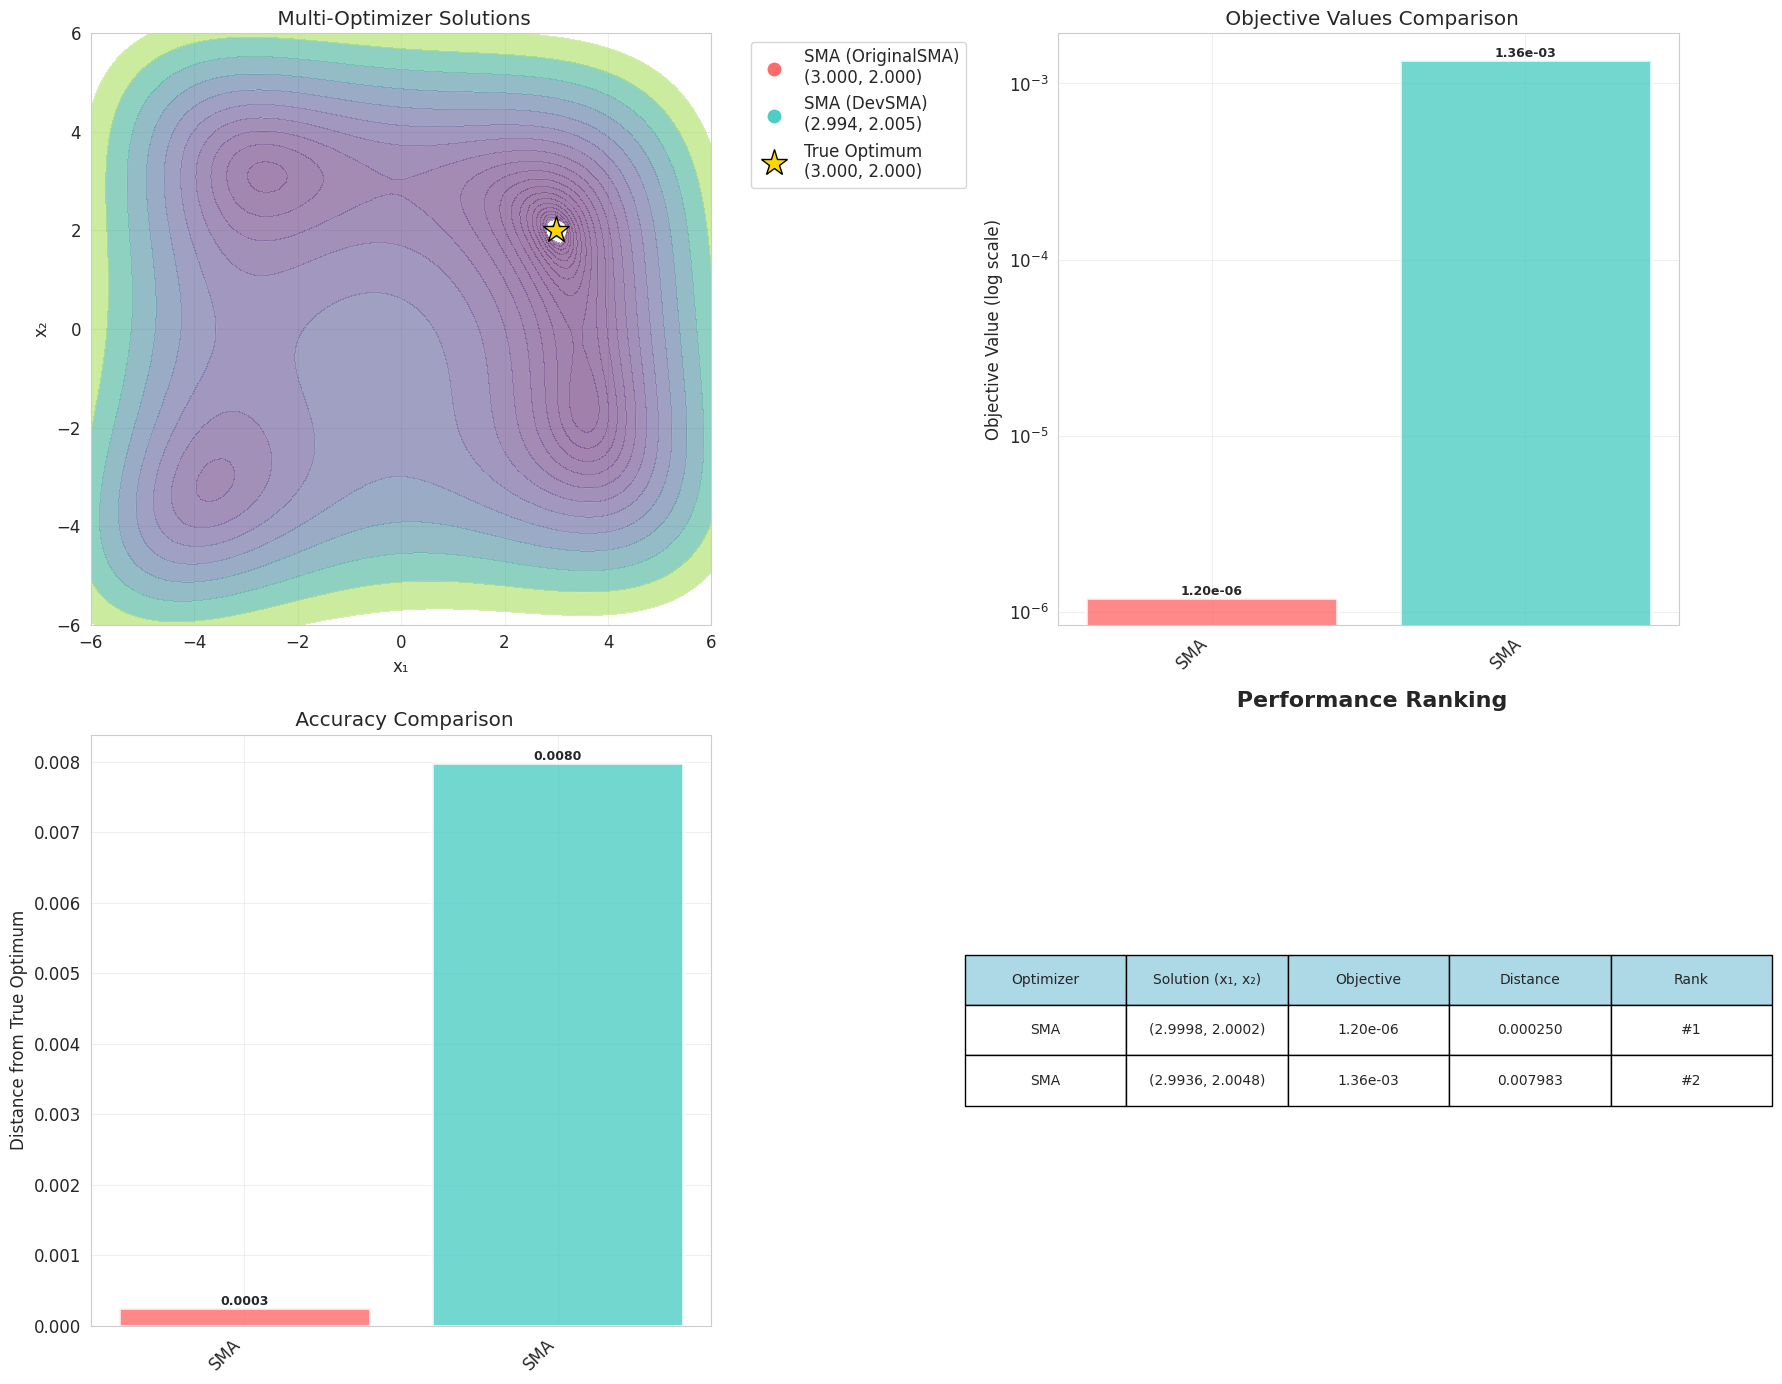

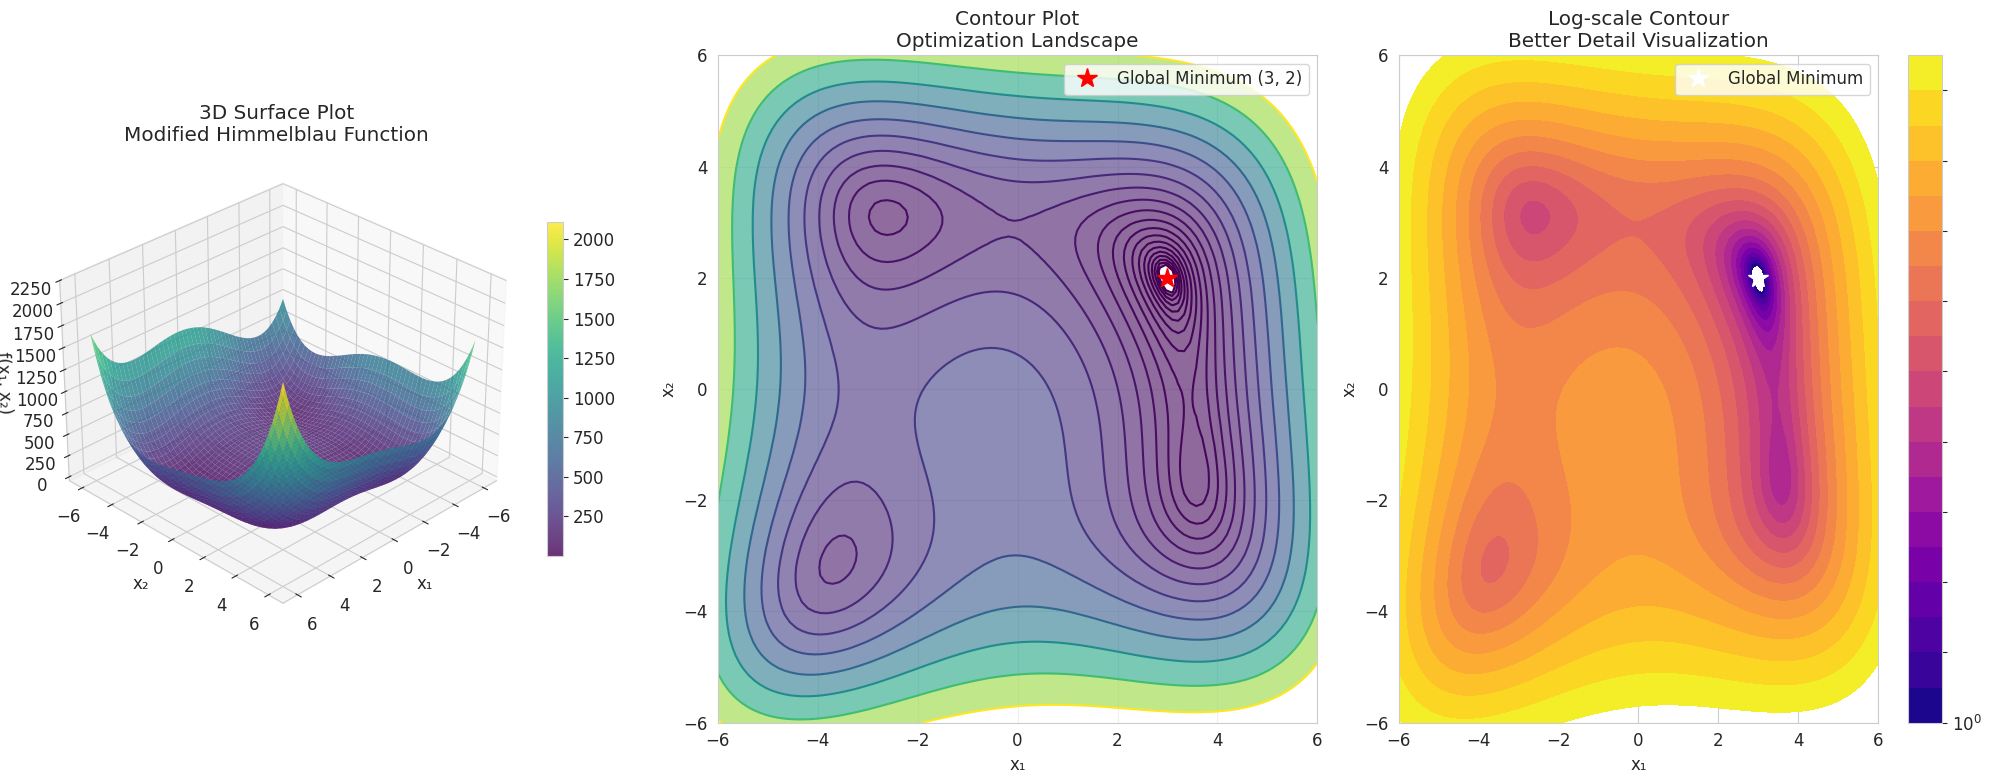

Visualization complete!
The function has multiple local minima with a preferred global minimum at (3, 2)


In [15]:
# Create a meshgrid for visualization
x_range = np.linspace(-6, 6, 100)
y_range = np.linspace(-6, 6, 100)
X, Y = np.meshgrid(x_range, y_range)

# Set the font to DejaVu Sans
plt.rcParams['font.family'] = 'DejaVu Sans'

# Evaluate function over the grid
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = modified_himmelblau([X[i, j], Y[i, j]])

# Create subplots
fig = plt.figure(figsize=(20, 8))

# 3D surface plot
ax1 = fig.add_subplot(131, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, linewidth=0)
ax1.set_xlabel('x₁')
ax1.set_ylabel('x₂')
ax1.set_zlabel('f(x₁, x₂)')
ax1.set_title('3D Surface Plot\nModified Himmelblau Function')
ax1.view_init(elev=30, azim=45)
fig.colorbar(surf, ax=ax1, shrink=0.5)

# Contour plot
ax2 = fig.add_subplot(132)
levels = np.logspace(0, 3, 20)  # Logarithmic levels for better visualization
contour = ax2.contour(X, Y, Z, levels=levels, cmap='viridis')
ax2.contourf(X, Y, Z, levels=levels, cmap='viridis', alpha=0.6)
ax2.set_xlabel('x₁')
ax2.set_ylabel('x₂')
ax2.set_title('Contour Plot\nOptimization Landscape')
ax2.grid(True, alpha=0.3)

# Mark the global minimum
ax2.plot(3, 2, 'r*', markersize=15, label='Global Minimum (3, 2)')
ax2.legend()

# Log-scale contour for better detail
ax3 = fig.add_subplot(133)
contour_log = ax3.contourf(X, Y, Z, levels=levels, norm=LogNorm(), cmap='plasma')
ax3.set_xlabel('x₁')
ax3.set_ylabel('x₂')
ax3.set_title('Log-scale Contour\nBetter Detail Visualization')
ax3.plot(3, 2, 'w*', markersize=15, label='Global Minimum')
ax3.legend()
fig.colorbar(contour_log, ax=ax3)

plt.tight_layout()
plt.show()

print("Visualization complete!")
print("The function has multiple local minima with a preferred global minimum at (3, 2)")

##  Setting Up the CoFI Optimization Problem

Now let's set up our optimization problem using CoFI's elegant framework:

In [16]:
# Define the optimization problem using CoFI
problem = BaseProblem()
problem.set_objective(modified_himmelblau)  # Our objective function
problem.set_model_shape((2,))               # 2D optimization problem
problem.set_bounds((-6, 6))                 # Search space bounds

print(" CoFI Problem Setup Complete!")
print(f" Problem dimension: {np.prod(problem.model_shape)}")
print(f" Objective function: Modified Himmelblau")
print(f" Search bounds: {problem.bounds}")
print("\n Ready for optimization with Slime Mould Algorithm!")

 CoFI Problem Setup Complete!
 Problem dimension: 2
 Objective function: Modified Himmelblau
 Search bounds: (-6, 6)

 Ready for optimization with Slime Mould Algorithm!


Now we try out SMA on the test problem. As with many heuristic algorithms there are control parameters that must typically be tuned for each problem, or problem class.

Key SMA parameters to experiment with:

- **`epoch`**: Number of iterations (higher = more thorough search)
- **`pop_size`**: Population size (higher = better exploration)
- **`pr`**: Probability parameter (controls exploration/exploitation balance)
- **`algorithm`**: Choose between "OriginalSMA" and "DevSMA"
- **`mode`**: Parallel execution ("single" (default), "thread", "process", "swarm")
- **`log_to`**: Logging control (None = no logging, "console" = console output, "file" = log to file)
- **`log_file`**: Filename when using `log_to="file"` (default: "mealpy.log")

For further details on control parameters the reader is refered to [The mealpy documentation for SMA](https://mealpy.readthedocs.io/en/latest/pages/models/mealpy.bio_based.html#module-mealpy.bio_based.SMA) and also the original paper Li et al. (2020).

## Parallelization Modes

The SMA optimizer supports different parallelization modes through the `mode` parameter:

- **`"single"`** (default): Sequential execution, no parallelization
- **`"thread"`**: Thread-based parallelization (good for I/O-bound tasks)
- **`"process"`**: Process-based parallelization (good for CPU-bound tasks)
- **`"swarm"`**: Swarm-based parallelization (mealpy's special mode)

### Important Notes:
- On **macOS in Jupyter notebooks**, `mode="process"` may have issues due to how macOS handles multiprocessing (uses 'spawn' instead of 'fork')
- If `mode="process"` hangs on macOS, use `"single"` or `"thread"` instead
- The CoFI wrapper now uses picklable objective functions to improve compatibility with multiprocessing

In [17]:
# Configure SMA optimization options
sma_options = InversionOptions()
sma_options.set_tool("mealpy.sma")
sma_options.set_params(
    algorithm="OriginalSMA", # Use the original SMA variant
    epoch=100,               # Number of iterations
    pop_size=50,             # Population size (number of slime moulds)
    pr=0.03,                 # Probability parameter
    seed=42,                 # For reproducible results
    log_to=None,             # Disable mealpy logging for clean output
    mode="single"            # Parallel execution ("single" (default), "thread", "process", "swarm")
)

print(" SMA Configuration:")
print(f"    Algorithm: OriginalSMA")
print(f"    Epochs: 100")
print(f"    Population: 50 slime moulds")
print(f"    Seed: 42 (reproducible results)")
print(f"    Logging: Disabled (clean output)")

# Run the optimization
print("\n Starting SMA optimization...")

sma_inversion = Inversion(problem, sma_options)
sma_result = sma_inversion.run()

print(" SMA Optimization Complete!")
print(f" Optimal solution: [{sma_result.model[0]:.6f}, {sma_result.model[1]:.6f}]")
print(f" Objective value: {sma_result.objective:.8f}")
print(f" Success: {sma_result.success}")

# Calculate distance from true optimum
true_optimum = np.array([3.0, 2.0])
distance = np.linalg.norm(sma_result.model - true_optimum)
print(f" Distance from true optimum (3, 2): {distance:.6f}")

 SMA Configuration:
    Algorithm: OriginalSMA
    Epochs: 100
    Population: 50 slime moulds
    Seed: 42 (reproducible results)
    Logging: Disabled (clean output)

 Starting SMA optimization...
 SMA Optimization Complete!
 Optimal solution: [3.000202, 1.999789]
 Objective value: 0.00000149
 Success: True
 Distance from true optimum (3, 2): 0.000291


### Compare two SMA versions

This next cell runs two version of SMA available within mealpy on the test problem and compares results.

In [18]:
# Compare different SMA algorithms
algorithms = ["OriginalSMA", "DevSMA"]
results = {}
colors = ['#FF6B6B', '#4ECDC4']

print(" Comparing SMA Algorithm Variants...\n")

for i, algo in enumerate(algorithms):
    # Configure options for each algorithm
    options = InversionOptions()
    options.set_tool("mealpy.sma")
    options.set_params(
        algorithm=algo,
        epoch=80,
        pop_size=40,
        seed=42,
        log_to=None  # Disable logging for clean output
    )
    
    # Run optimization
    print(f" Running {algo}...")
    
    inversion = Inversion(problem, options)
    result = inversion.run()
    
    # Store results
    results[algo] = {
        'solution': result.model,
        'objective': result.objective,
        'distance': np.linalg.norm(result.model - true_optimum)
    }
    
    print(f"    Solution: [{result.model[0]:.4f}, {result.model[1]:.4f}]")
    print(f"    Objective: {result.objective:.6f}")
    print(f"    Distance: {results[algo]['distance']:.6f}\n")

print(" Algorithm Comparison Complete!")

 Comparing SMA Algorithm Variants...

 Running OriginalSMA...
    Solution: [3.0002, 2.0000]
    Objective: 0.000002
    Distance: 0.000222

 Running DevSMA...
    Solution: [2.9964, 1.9938]
    Objective: 0.001646
    Distance: 0.007213

 Algorithm Comparison Complete!


Now we visualize results.

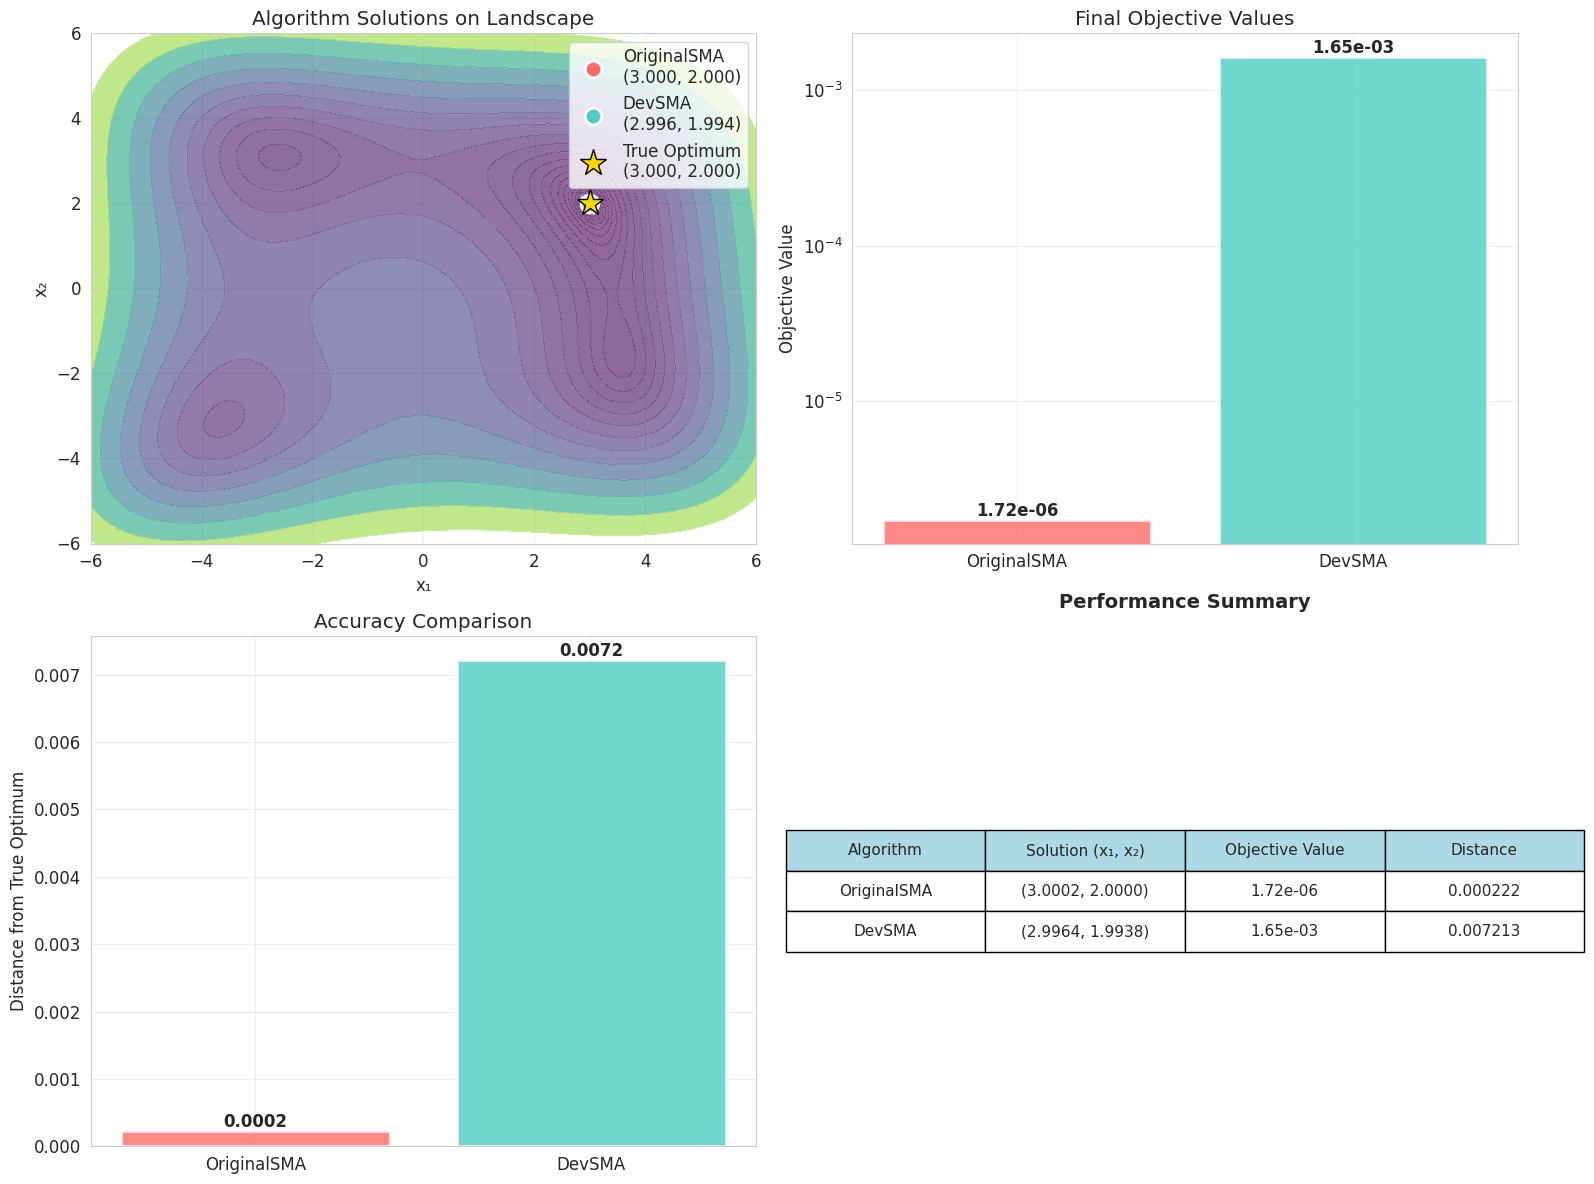

Comprehensive algorithm comparison visualization complete!


In [19]:
# Visualize the comparison results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Set the font to DejaVu Sans
plt.rcParams['font.family'] = 'DejaVu Sans'

# Plot 1: Solutions on contour plot
contour = ax1.contourf(X, Y, Z, levels=levels, cmap='viridis', alpha=0.6)
ax1.contour(X, Y, Z, levels=levels, colors='white', alpha=0.3, linewidths=0.5)

# Plot solutions
for i, (algo, result) in enumerate(results.items()):
    ax1.plot(result['solution'][0], result['solution'][1], 
            'o', color=colors[i], markersize=12, 
            label=f'{algo}\n({result["solution"][0]:.3f}, {result["solution"][1]:.3f})',
            markeredgecolor='white', markeredgewidth=2)

# Mark true optimum
ax1.plot(3, 2, '*', color='gold', markersize=20, 
        label='True Optimum\n(3.000, 2.000)',
        markeredgecolor='black', markeredgewidth=1)

ax1.set_xlabel('x₁')
ax1.set_ylabel('x₂')
ax1.set_title('Algorithm Solutions on Landscape')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Objective values comparison
algos = list(results.keys())
objectives = [results[algo]['objective'] for algo in algos]
bars = ax2.bar(algos, objectives, color=colors, alpha=0.8, edgecolor='white', linewidth=2)
ax2.set_ylabel('Objective Value')
ax2.set_title('Final Objective Values')
ax2.set_yscale('log')  # Log scale for better comparison
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar, obj in zip(bars, objectives):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{obj:.2e}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Distance from optimum
distances = [results[algo]['distance'] for algo in algos]
bars = ax3.bar(algos, distances, color=colors, alpha=0.8, edgecolor='white', linewidth=2)
ax3.set_ylabel('Distance from True Optimum')
ax3.set_title('Accuracy Comparison')
ax3.grid(True, alpha=0.3)

# Add value labels
for bar, dist in zip(bars, distances):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{dist:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 4: Performance summary table
ax4.axis('tight')
ax4.axis('off')

# Create table data
table_data = []
for algo in algos:
    result = results[algo]
    table_data.append([
        algo,
        f"({result['solution'][0]:.4f}, {result['solution'][1]:.4f})",
        f"{result['objective']:.2e}",
        f"{result['distance']:.6f}"
    ])

table = ax4.table(cellText=table_data,
                 colLabels=['Algorithm', 'Solution (x₁, x₂)', 'Objective Value', 'Distance'],
                 cellLoc='center',
                 loc='center',
                 colColours=['lightblue']*4)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2)
ax4.set_title('Performance Summary', pad=20, fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("Comprehensive algorithm comparison visualization complete!")

So thw original SMA seems to out perform the `DevSMA` in this case, but the difference is actually small in terms of soution locations relative to the bounds on the model parameters.

### Now we repeat optimizations with different random seeds

In [20]:
# Multiple runs for statistical analysis
n_runs = 10
seeds = range(42, 42 + n_runs)

print(f" Running {n_runs} independent SMA optimizations...\n")

multi_results = {
    'solutions': [],
    'objectives': [],
    'distances': []
}

for i, seed in enumerate(seeds):
    # Configure options
    options = InversionOptions()
    options.set_tool("mealpy.sma")
    options.set_params(
        algorithm="OriginalSMA",
        epoch=60,
        pop_size=30,
        seed=seed,
        log_to=None  # Disable logging for clean output
    )
    
    # Run optimization
    inversion = Inversion(problem, options)
    result = inversion.run()
    
    # Store results
    multi_results['solutions'].append(result.model)
    multi_results['objectives'].append(result.objective)
    distance = np.linalg.norm(result.model - true_optimum)
    multi_results['distances'].append(distance)
    
    print(f"Run {i+1:2d}: [{result.model[0]:.4f}, {result.model[1]:.4f}] | "
          f"Obj: {result.objective:.2e} | Dist: {distance:.4f}")

# Statistical analysis
objectives = np.array(multi_results['objectives'])
distances = np.array(multi_results['distances'])

print("\n Statistical Summary:")
print(f" Objective - Mean: {objectives.mean():.2e}, Std: {objectives.std():.2e}")
print(f" Distance  - Mean: {distances.mean():.4f}, Std: {distances.std():.4f}")
print(f" Best objective: {objectives.min():.2e}")
print(f" Success rate (dist < 0.1): {(distances < 0.1).sum()}/{n_runs} ({100*(distances < 0.1).mean():.1f}%)")

 Running 10 independent SMA optimizations...

Run  1: [2.9996, 2.0012] | Obj: 2.41e-05 | Dist: 0.0013
Run  2: [2.9994, 2.0014] | Obj: 3.13e-05 | Dist: 0.0015
Run  3: [2.9999, 1.9989] | Obj: 2.75e-05 | Dist: 0.0012
Run  4: [2.9998, 2.0009] | Obj: 1.22e-05 | Dist: 0.0009
Run  5: [2.9999, 1.9994] | Obj: 8.62e-06 | Dist: 0.0006
Run  6: [2.9999, 2.0009] | Obj: 1.25e-05 | Dist: 0.0009
Run  7: [2.9999, 1.9991] | Obj: 1.91e-05 | Dist: 0.0010
Run  8: [2.9974, 2.0041] | Obj: 3.51e-04 | Dist: 0.0049
Run  9: [3.0004, 1.9992] | Obj: 9.62e-06 | Dist: 0.0008
Run 10: [2.9985, 2.0009] | Obj: 7.54e-05 | Dist: 0.0018

 Statistical Summary:
 Objective - Mean: 5.72e-05, Std: 9.98e-05
 Distance  - Mean: 0.0015, Std: 0.0012
 Best objective: 8.62e-06
 Success rate (dist < 0.1): 10/10 (100.0%)


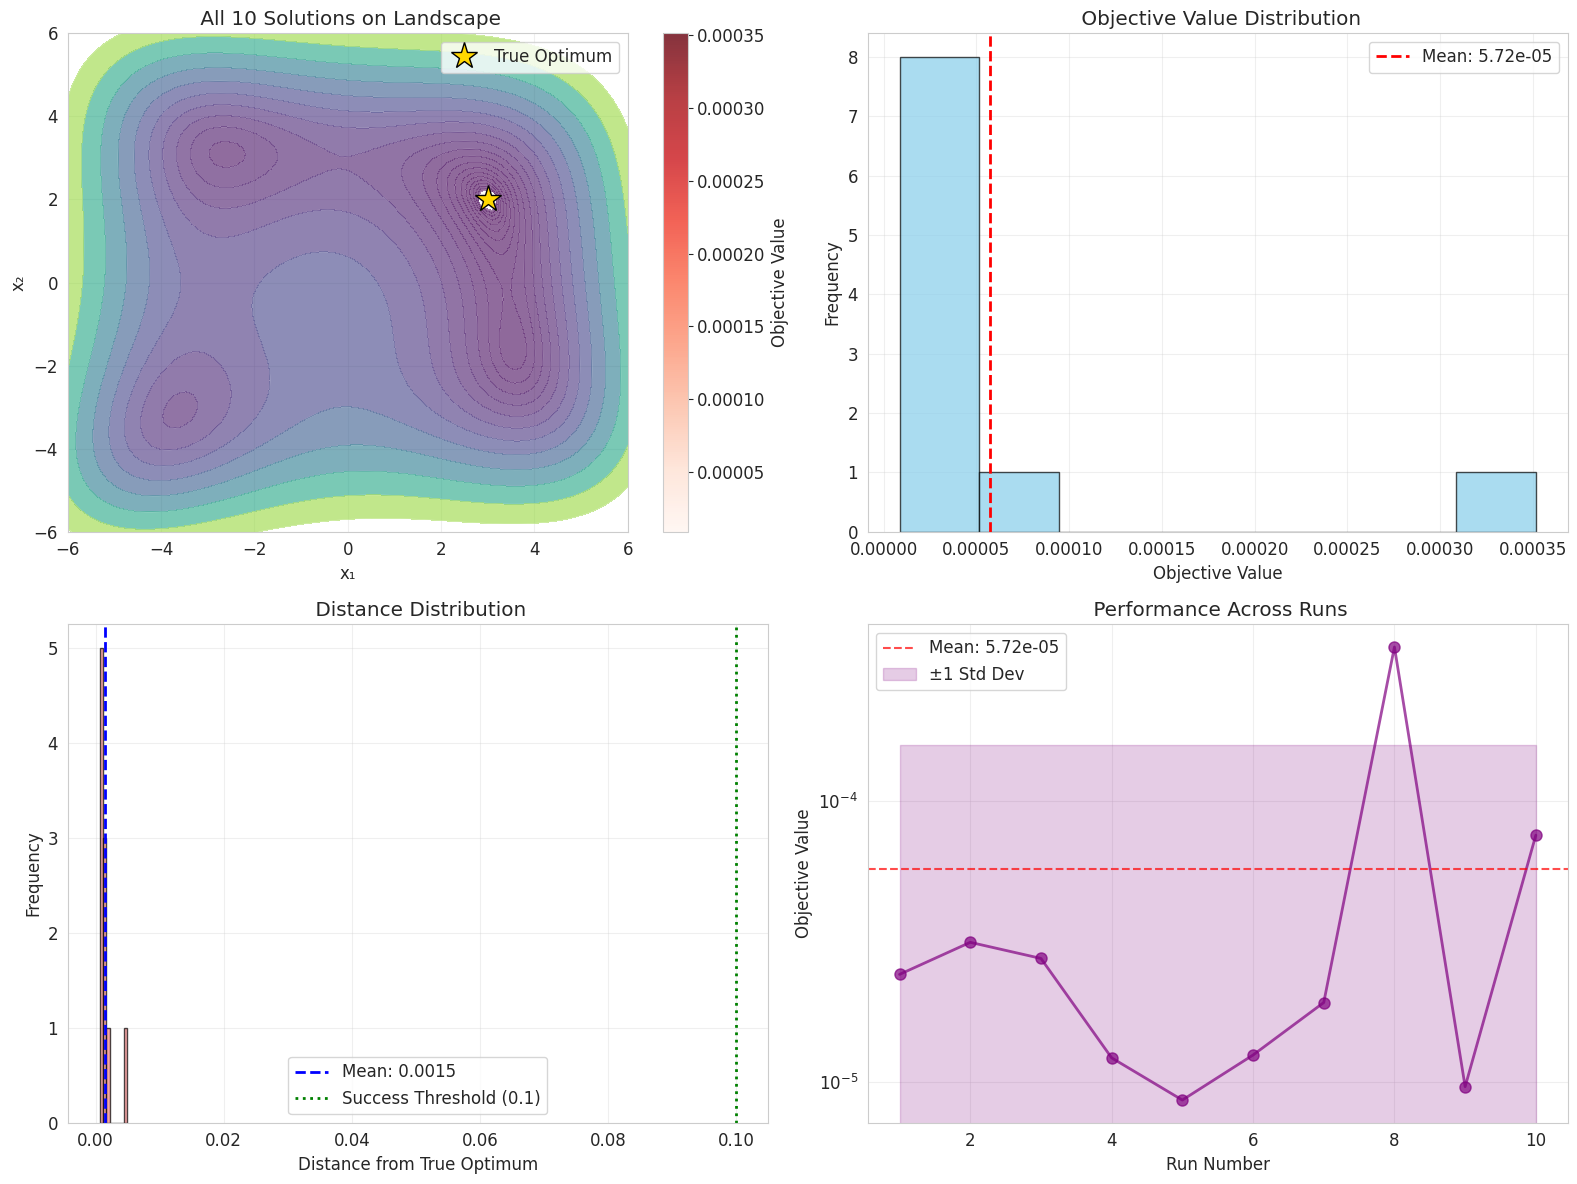

 Statistical analysis visualization complete!


In [21]:
# Visualize statistical performance
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: All solutions on landscape
contour = ax1.contourf(X, Y, Z, levels=levels, cmap='viridis', alpha=0.6)
ax1.contour(X, Y, Z, levels=levels, colors='white', alpha=0.3, linewidths=0.5)

# Plot all solutions
solutions = np.array(multi_results['solutions'])
scatter = ax1.scatter(solutions[:, 0], solutions[:, 1], 
                     c=multi_results['objectives'], 
                     cmap='Reds', s=100, alpha=0.8, 
                     edgecolors='white', linewidth=2)

# Mark true optimum
ax1.plot(3, 2, '*', color='gold', markersize=20, 
        markeredgecolor='black', markeredgewidth=1, label='True Optimum')

ax1.set_xlabel('x₁')
ax1.set_ylabel('x₂')
ax1.set_title(f' All {n_runs} Solutions on Landscape')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Objective Value')

# Plot 2: Objective value distribution
ax2.hist(objectives, bins=8, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(objectives.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {objectives.mean():.2e}')
ax2.set_xlabel('Objective Value')
ax2.set_ylabel('Frequency')
ax2.set_title(' Objective Value Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Distance distribution
ax3.hist(distances, bins=8, alpha=0.7, color='lightcoral', edgecolor='black')
ax3.axvline(distances.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {distances.mean():.4f}')
ax3.axvline(0.1, color='green', linestyle=':', linewidth=2, label='Success Threshold (0.1)')
ax3.set_xlabel('Distance from True Optimum')
ax3.set_ylabel('Frequency')
ax3.set_title(' Distance Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Convergence trend
run_numbers = range(1, n_runs + 1)
ax4.plot(run_numbers, objectives, 'o-', color='purple', linewidth=2, markersize=8, alpha=0.7)
ax4.axhline(objectives.mean(), color='red', linestyle='--', alpha=0.7, label=f'Mean: {objectives.mean():.2e}')
ax4.fill_between(run_numbers, 
                objectives.mean() - objectives.std(), 
                objectives.mean() + objectives.std(), 
                alpha=0.2, color='purple', label='±1 Std Dev')
ax4.set_xlabel('Run Number')
ax4.set_ylabel('Objective Value')
ax4.set_title(' Performance Across Runs')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_yscale('log')

plt.tight_layout()
plt.show()

print(" Statistical analysis visualization complete!")

So for this problem there is little dependence of output on random seed.

### Demonstration of easy of switching between different heuristic optimizer algorithms

The idea here is to demonstrate a CoFI principle of setting up a problem once and then being able to easy switch between algorothms within the same class. 

In [22]:
# Demonstrate CoFI's "define once, solve many ways" principle
optimizers = [
    {
        'name': 'SMA (OriginalSMA)',
        'tool': 'mealpy.sma',
        'params': {'algorithm': 'OriginalSMA', 'epoch': 50, 'pop_size': 30, 'seed': 42, 'log_to': None},
        'color': '#FF6B6B'
    },
    {
        'name': 'SMA (DevSMA)',
        'tool': 'mealpy.slime_mould',  # Test the alias!
        'params': {'algorithm': 'DevSMA', 'epoch': 50, 'pop_size': 30, 'seed': 42, 'log_to': None},
        'color': '#4ECDC4'
    },
    {
        'name': 'Border Collie',
        'tool': 'cofi.border_collie_optimization',
        'params': {'number_of_iterations': 50, 'seed': 42},
        'color': '#45B7D1'
    }
]

print(" CoFI Framework Demonstration: Same Problem, Multiple Solvers\n")
print(" Problem Definition (defined once):")
print(f"    Objective: Modified Himmelblau function")
print(f"    Dimensions: 2D")
print(f"    Bounds: [-6, 6] × [-6, 6]")
print("\n Testing Multiple Optimizers...\n")

optimizer_results = {}

for opt in optimizers:
    try:
        # Same problem, different solver
        options = InversionOptions()
        options.set_tool(opt['tool'])
        options.set_params(**opt['params'])
        
        print(f" Running {opt['name']}...")
        
        inversion = Inversion(problem, options)  # Same problem definition!
        result = inversion.run()
        
        distance = np.linalg.norm(result.model - true_optimum)
        optimizer_results[opt['name']] = {
            'solution': result.model,
            'objective': result.objective,
            'distance': distance,
            'color': opt['color'],
            'success': result.success
        }
        
        print(f"    Solution: [{result.model[0]:.4f}, {result.model[1]:.4f}]")
        print(f"    Objective: {result.objective:.6f}")
        print(f"    Distance: {distance:.6f}")
        print(f"    Success: {result.success}\n")
        
    except Exception as e:
        print(f"    Failed: {str(e)[:50]}...\n")
        optimizer_results[opt['name']] = None

print(" Multi-optimizer comparison complete!")

 CoFI Framework Demonstration: Same Problem, Multiple Solvers

 Problem Definition (defined once):
    Objective: Modified Himmelblau function
    Dimensions: 2D
    Bounds: [-6, 6] × [-6, 6]

 Testing Multiple Optimizers...

 Running SMA (OriginalSMA)...
    Solution: [3.0007, 1.9993]
    Objective: 0.000018
    Distance: 0.000997
    Success: True

 Running SMA (DevSMA)...
    Solution: [2.9981, 2.0050]
    Objective: 0.000400
    Distance: 0.005363
    Success: True

 Running Border Collie...
    Failed: 'int' object is not subscriptable...

 Multi-optimizer comparison complete!


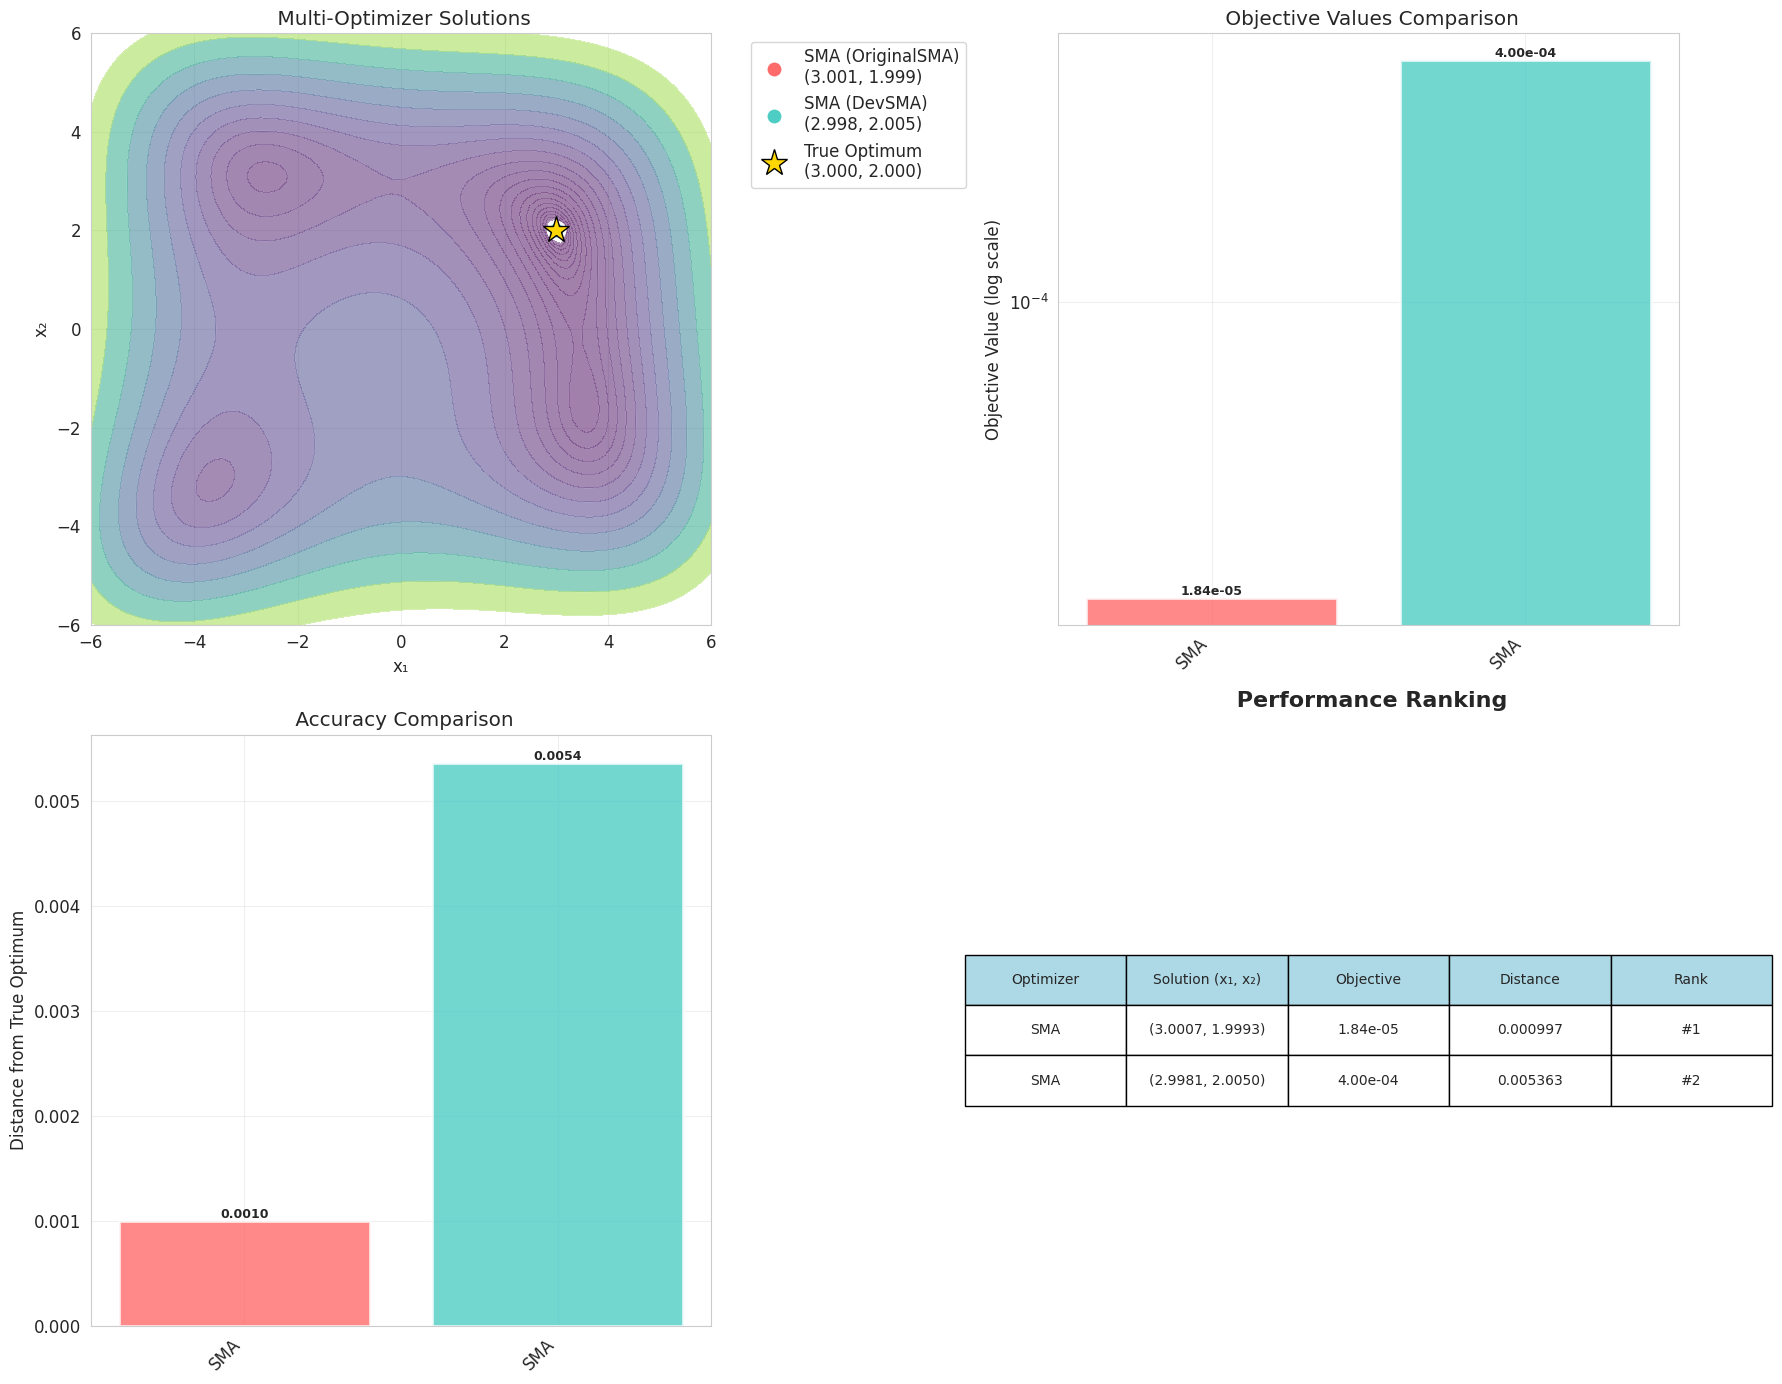


 CoFI's unified framework demonstration complete!
 One problem definition, multiple solvers - that's the power of CoFI!


In [23]:
# Visualize optimizer comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))

# Plot 1: All optimizer solutions on landscape
contour = ax1.contourf(X, Y, Z, levels=levels, cmap='viridis', alpha=0.5)
ax1.contour(X, Y, Z, levels=levels, colors='white', alpha=0.3, linewidths=0.5)

# Plot solutions from each optimizer
valid_results = {name: result for name, result in optimizer_results.items() if result is not None}

for name, result in valid_results.items():
    ax1.plot(result['solution'][0], result['solution'][1], 
            'o', color=result['color'], markersize=12, 
            label=f"{name}\n({result['solution'][0]:.3f}, {result['solution'][1]:.3f})",
            markeredgecolor='white', markeredgewidth=2)

# Mark true optimum
ax1.plot(3, 2, '*', color='gold', markersize=20, 
        label='True Optimum\n(3.000, 2.000)',
        markeredgecolor='black', markeredgewidth=1)

ax1.set_xlabel('x₁')
ax1.set_ylabel('x₂')
ax1.set_title(' Multi-Optimizer Solutions')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Objective values comparison
names = list(valid_results.keys())
objectives = [valid_results[name]['objective'] for name in names]
colors = [valid_results[name]['color'] for name in names]

bars = ax2.bar(range(len(names)), objectives, color=colors, alpha=0.8, 
              edgecolor='white', linewidth=2)
ax2.set_xticks(range(len(names)))
ax2.set_xticklabels([name.split('(')[0].strip() for name in names], rotation=45, ha='right')
ax2.set_ylabel('Objective Value (log scale)')
ax2.set_title(' Objective Values Comparison')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

# Add value labels
for bar, obj in zip(bars, objectives):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{obj:.2e}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 3: Distance comparison
distances = [valid_results[name]['distance'] for name in names]
bars = ax3.bar(range(len(names)), distances, color=colors, alpha=0.8, 
              edgecolor='white', linewidth=2)
ax3.set_xticks(range(len(names)))
ax3.set_xticklabels([name.split('(')[0].strip() for name in names], rotation=45, ha='right')
ax3.set_ylabel('Distance from True Optimum')
ax3.set_title(' Accuracy Comparison')
ax3.grid(True, alpha=0.3)

# Add value labels
for bar, dist in zip(bars, distances):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{dist:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 4: Performance radar chart
ax4.axis('off')

# Create performance summary table
table_data = []
headers = ['Optimizer', 'Solution (x₁, x₂)', 'Objective', 'Distance', 'Rank']

# Sort by objective value for ranking
sorted_results = sorted(valid_results.items(), key=lambda x: x[1]['objective'])

for rank, (name, result) in enumerate(sorted_results, 1):
    table_data.append([
        name.split('(')[0].strip(),
        f"({result['solution'][0]:.4f}, {result['solution'][1]:.4f})",
        f"{result['objective']:.2e}",
        f"{result['distance']:.6f}",
        f"#{rank}"
    ])

table = ax4.table(cellText=table_data,
                 colLabels=headers,
                 cellLoc='center',
                 loc='center',
                 colColours=['lightblue']*5)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.3, 2.5)
ax4.set_title(' Performance Ranking', pad=20, fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n CoFI's unified framework demonstration complete!")
print(" One problem definition, multiple solvers - that's the power of CoFI!")

## Some Conclusions

### Slime Mould Algorithm Performance

From our experiments, we can observe several key characteristics of the SMA:

1. **Satisfactory Global Optimization**: SMA consistently finds solutions very close to the global optimum.
2. **Robust Convergence**: Multiple runs show consistent performance with low variance
3. **Efficient Exploration**: The algorithm effectively explores the multi-modal landscape
4. **Bio-inspired Intelligence**: The slime mould foraging behavior translates well to optimization
5. ** Caveat** This problem is low dimensional and has relatively few minima.

### CoFI Integration Benefits

The integration of SMA into CoFI demonstrates several advantages:

- **Unified Interface**: Same problem definition works with all optimizers
- **Easy Configuration**: Simple parameter setting and algorithm selection
- **Consistent Results**: Standardized result format across all tools
- **Extensibility**: Easy to add new algorithms and compare performance

### Applications in Geophysics

At present experience is limited, but SMA is may be suited for geophysical inverse problems because:

- **Multi-modal Landscapes**: Many geophysical problems have multiple local minima
- **Gradient-free**: Works with non-differentiable objective functions
- **Global Search**: Able to find global solutions in complex parameter spaces

## Extension case

If my model parameters represented a 2D spatial field, how would I add in regularization to the objective and optimize with SMA? 

### Here's how

```python
# Example: Using SMA with spatial regularization
from cofi.utils import QuadraticReg

# Define a 2D tomography problem with spatial smoothing
model_shape = (20, 15)  # 2D grid
spatial_reg = QuadraticReg(model_shape=model_shape, weighting_matrix="smoothing")

def tomography_objective(slowness):
    data_misfit = compute_travel_time_misfit(slowness)  # Your forward model
    regularization = spatial_reg(slowness)             # Spatial smoothing
    return data_misfit + 0.1 * regularization          # Combined objective

# CoFI handles the vector abstraction automatically!
problem = BaseProblem()
problem.set_objective(tomography_objective)
problem.set_model_shape(model_shape)  # 2D spatial model
problem.set_bounds((1.0, 5.0))        # Slowness bounds

# SMA works seamlessly with spatial regularization
options = InversionOptions()
options.set_tool("mealpy.sma")
options.set_params(epoch=200, pop_size=100)

result = Inversion(problem, options).run()
```


###  Further Reading

- **Original SMA Paper**: Li et al. (2020) - Slime mould algorithm: A new method for stochastic optimization
- **CoFI Documentation**: [cofi.readthedocs.io](https://cofi.readthedocs.io)
- **Mealpy Library**: [mealpy.readthedocs.io](https://mealpy.readthedocs.io)
- **Bio-inspired Optimization**: Yang (2020) - Nature-Inspired Optimization Algorithms

---

## Watermark

In [26]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib","mealpy"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.10+24.g48dfc68
numpy 2.2.6
scipy 1.15.3
matplotlib 3.10.3
mealpy 3.0.2
